<font size="5">Section 6: Machine Learning</font>

## Housekeeping and Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from pywaffle import Waffle

import yellowbrick
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap

%matplotlib inline

## Lasso Regression (Regularization)

In [3]:
df_store=pd.read_csv('../data/ifood_df.csv')
target = df_store.MntTotal
features = df_store.drop('MntTotal', axis=1)
features.describe()

,Recency,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntRegularProds,AcceptedCmpOverall
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.00000
mean,49.009070,51622.094785,0.442177,0.506576,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,0.216327,0.257596,0.034467,0.089796,0.024490,0.504762,0.165079,0.215873,518.707483,0.29932
std,28.932111,20713.063826,0.537132,0.544380,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,...,0.411833,0.437410,0.182467,0.285954,0.154599,0.500091,0.371336,0.411520,553.847248,0.68044
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-283.000000,0.00000
25%,24.000000,35196.000000,0.000000,0.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.00000
50%,49.000000,51287.000000,0.000000,0.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,288.000000,0.00000
75%,74.000000,68281.000000,1.000000,1.000000,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,884.000000,0.00000
max,99.000000,113734.000000,2.000000,2.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2458.000000,4.00000


<Axes: xlabel='MntTotal', ylabel='Count'>

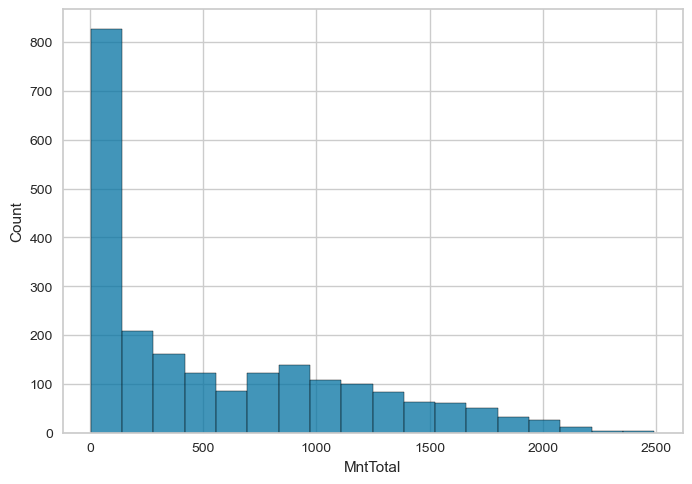

In [4]:
sns.histplot(data=target)

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Train the Lasso regression model
lasso=Lasso(alpha=0.1, 
            max_iter=10000,
            tol=0.0001)  # You can adjust the alpha value to control the regularization strength
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, max_iter=10000)

In [11]:
# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.11499662979609987


In [12]:
# define model evaluation method
cv = RepeatedKFold(n_splits=100, n_repeats=3, random_state=1)
# cross validation scores
scores = cross_val_score(lasso, X_train_scaled, y_train, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
scores=absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean RMSE: 0.120 (0.021)


<AxesSubplot:xlabel='MntTotal', ylabel='Predicted'>

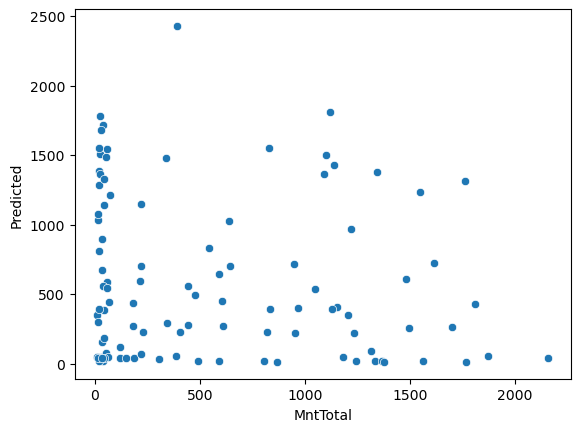

In [124]:
y_pred=pd.DataFrame(y_pred)
y_pred.rename(columns={0 :'Predicted'}, inplace=True )
test = pd.concat([y_test, y_pred], axis=1, join='inner')
sns.scatterplot(data=test, x='MntTotal', y='Predicted')

Feature importance

In [13]:
eli5.show_weights(lasso, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+563.962,<BIAS>
+338.685,MntWines
+216.609,MntMeatProducts
+55.812,MntFishProducts
+41.220,MntSweetProducts
+39.984,MntFruits
+0.418,MntRegularProds
+0.024,NumCatalogPurchases


Tuning alpha

In [14]:
# define model
model = LassoCV(n_alphas=100, cv=cv, n_jobs=-1, max_iter=10000)
# fit model
model.fit(X_train_scaled, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.574118


## Clasification

### Random Forest

In [15]:
target = df_store.Response
features = df_store.drop('Response', axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)

# Evaluating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8820861678004536


Out of the negative response cases (no response) 370 out of 414 are accurately classified, and 19 out of 27 for positive response cases. Total accuracy is 88.2 percent.

In [17]:
confusion_matrix(y_test, y_pred)

array([[370,   8],
       [ 44,  19]], dtype=int64)

Feature importance

<BarContainer object of 38 artists>

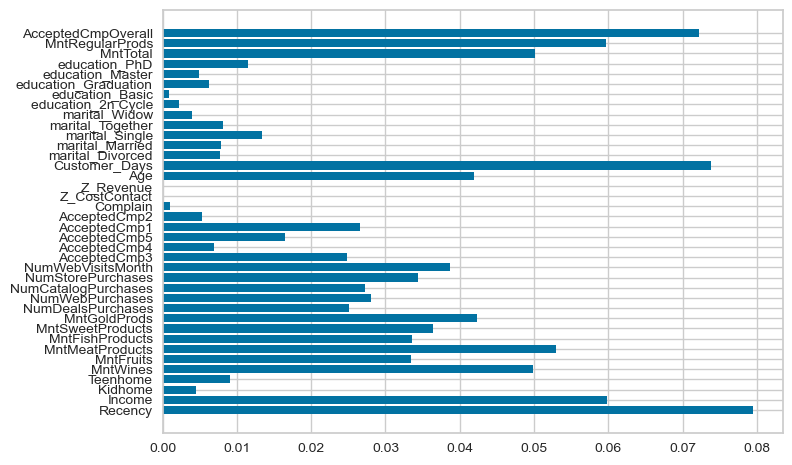

In [18]:
plt.barh(features.columns, rf.feature_importances_)

Now we can turn to tuning the hyperparameters.

In [19]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 8, 16],
    'max_features': [6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

In [21]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
True_16_8_3_12_100,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",1,0.889471,0.013583
True_16_6_4_12_200,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",2,0.887776,0.015434
True_16_8_4_12_100,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",3,0.887773,0.016650
True_16_8_3_8_300,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",4,0.887208,0.017145
True_16_8_3_12_200,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",5,0.887201,0.010740
...,...,...,...,...
True_4_6_3_12_300,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",158,0.865672,0.017198
True_4_6_3_12_100,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",158,0.865672,0.016428
True_4_6_5_10_200,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",160,0.865668,0.016063


### Boosting

In [23]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,   max_depth=1, random_state=42).fit(X_train, y_train)

# Making predictions on the test set
y_pred = gb.predict(X_test)

# Evaluating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8775510204081632


Tuning

In [24]:
## Considerando Grid Search
gb = GradientBoostingClassifier()
parameters = {'learning_rate': [0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5],
                  'n_estimators' : [100,200,300],
                  'max_depth'    : [4,6,8]}

grid_GBR = GridSearchCV(estimator=gb, param_grid = parameters, cv = 8, n_jobs=-1)
grid_GBR.fit(X_train_scaled, y_train)   

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.9, 0.5]})

In [25]:
results_df = pd.DataFrame(grid_GBR.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.04_4_300_0.5,"{'learning_rate': 0.04, 'max_depth': 4, 'n_est...",1,0.893424,0.005669
0.03_4_300_0.5,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est...",2,0.891723,0.000567
0.03_4_300_0.9,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est...",2,0.891723,0.005102
0.04_4_300_0.9,"{'learning_rate': 0.04, 'max_depth': 4, 'n_est...",4,0.891156,0.002268
0.02_4_300_0.9,"{'learning_rate': 0.02, 'max_depth': 4, 'n_est...",5,0.890590,0.000567
0.02_8_300_0.5,"{'learning_rate': 0.02, 'max_depth': 8, 'n_est...",6,0.890023,0.004535
0.02_4_200_0.9,"{'learning_rate': 0.02, 'max_depth': 4, 'n_est...",7,0.889456,0.001701
0.02_6_300_0.5,"{'learning_rate': 0.02, 'max_depth': 6, 'n_est...",8,0.888322,0.001701
0.04_4_200_0.9,"{'learning_rate': 0.04, 'max_depth': 4, 'n_est...",8,0.888322,0.005102


### Support Vector Machine

In [27]:
from sklearn import svm

svm_m = svm.SVC()
svm_m.fit(X_train, y_train)

y_pred = svm_m.predict(X_test)

# Evaluating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8571428571428571


Tuning

In [30]:
# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
              'kernel': ['rbf']} 
  
grid_SVM = GridSearchCV(svm_m, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_SVM.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             verbose=3)

In [31]:
results_df = pd.DataFrame(grid_SVM.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_0.0001_rbf,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",1,0.856010,0.004839
1_0.01_rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",2,0.855444,0.004695
1000_0.001_rbf,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",2,0.855444,0.004695
1000_0.01_rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",2,0.855444,0.004695
1000_0.1_rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",2,0.855444,0.004695
1000_1_rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",2,0.855444,0.004695
100_0.001_rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",2,0.855444,0.004695
100_0.01_rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",2,0.855444,0.004695
100_0.1_rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",2,0.855444,0.004695


### Stacking

In [33]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=16, max_features=8, min_samples_split=8, random_state=42)),
    ('boost', GradientBoostingClassifier(n_estimators=300, learning_rate=0.04, max_depth=8, random_state=42)),
    ('svc', svm.SVC(C=1, gamma=0.0001))]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stack.fit(X_train, y_train).score(X_test, y_test)

0.8820861678004536

In [34]:
cv = cross_val_score(stack, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print('Accuracy: %.6f' % round(np.mean(cv),6))

Accuracy: 0.882085


## Clustering

### K-means

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


1    530
0    516
2    363
3    355
dtype: int64

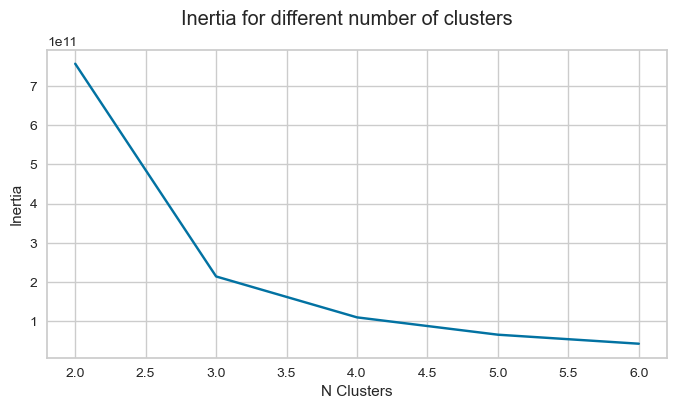

In [30]:
total_clusters = 5
param_search = pd.DataFrame({
    "N Clusters": np.arange(2,total_clusters+2,dtype=int), 
    "Inertia": [0]*total_clusters
})
for n_clusters in range(total_clusters):
    param_search.loc[n_clusters, "Inertia"] = KMeans(n_clusters=n_clusters+1, random_state=1).fit(X_train).inertia_

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(data=param_search, x="N Clusters", y="Inertia", ax=ax)
fig.suptitle("Inertia for different number of clusters")
fig.show()

n_clusters = 4
cluster_labels = pd.Series(KMeans(n_clusters=n_clusters, random_state=1).fit(X_train).labels_)
cluster_labels.value_counts()


Text(36.82804157433786, 0.5, 'Income')

<Figure size 1500x800 with 0 Axes>

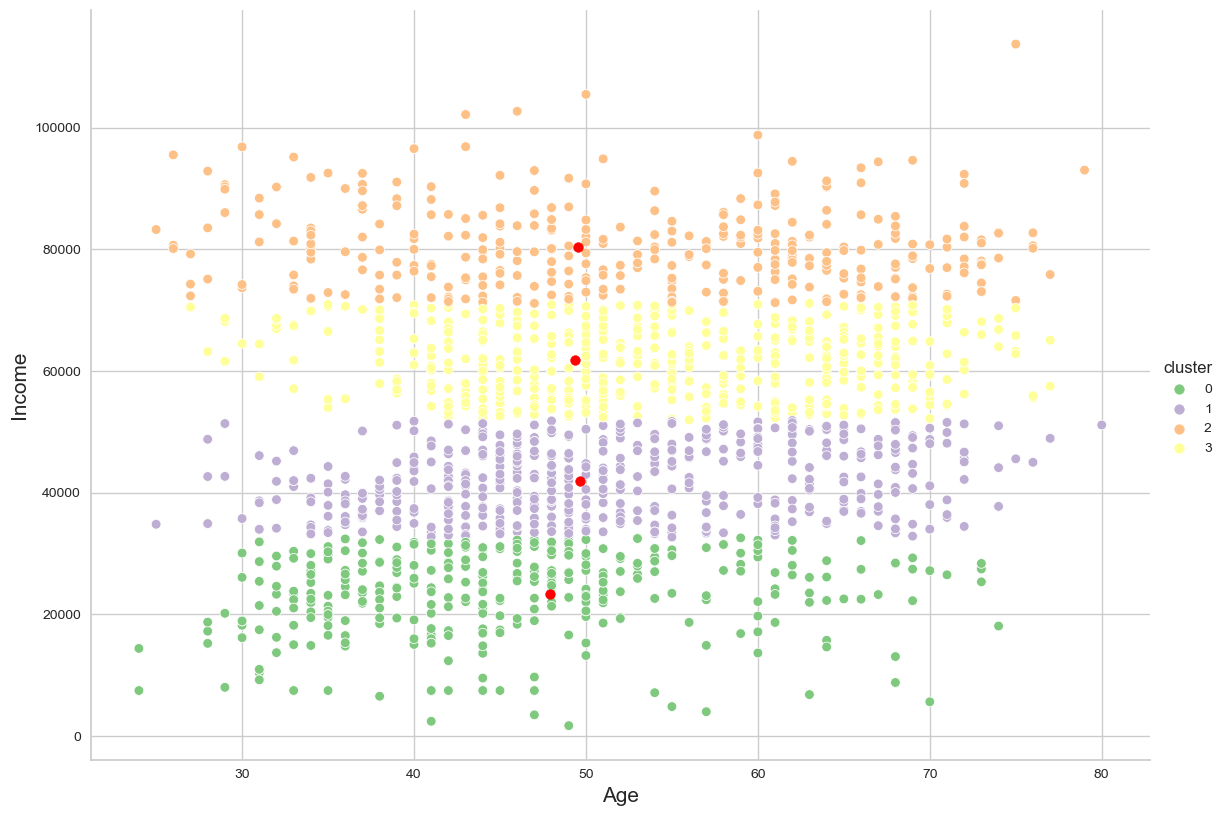

In [31]:
kmeans = KMeans(n_clusters=4, random_state=32, max_iter=500,n_init=5)
y_kmeans = kmeans.fit_predict(X_train)

kmeans = KMeans(n_clusters=4,init= "random", random_state = 1).fit(X_train)
centroids = kmeans.cluster_centers_
plt.figure(figsize=(15,8))
Data_kmean = X_train.copy()
Data_kmean['cluster'] = kmeans.labels_
sns.relplot(data = Data_kmean ,x='Age' , y  ='Income', hue='cluster', palette='Accent' ,kind='scatter', height=8.27, aspect = 11.7/8.27)
plt.scatter(centroids[:, 0], centroids[:,1], c='red', s=50)
plt.xlabel("Age",fontsize=15)
plt.ylabel("Income",fontsize=15)

### DBSCAN

In [32]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

Number of clusters: 3


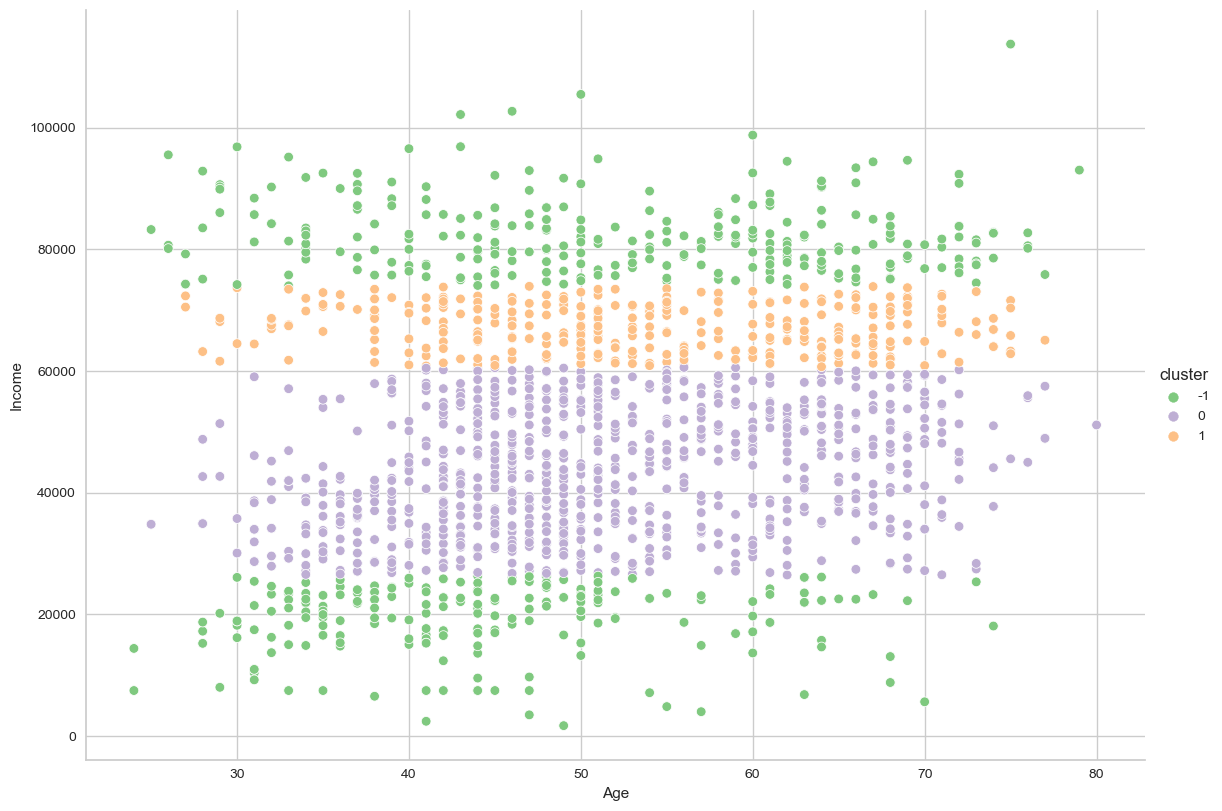

In [33]:
dbscan = DBSCAN(eps=2100, min_samples=100)
# Fit the DBSCAN model to the data
dbscan.fit(X_train)
# Extract the cluster labels
labels = dbscan.labels_
# Print the number of clusters
n_clusters = len(np.unique(labels))
print(f"Number of clusters: {n_clusters}")

data_dbscan = X_train.copy()
data_dbscan['cluster'] = dbscan.labels_
sns.relplot(data = data_dbscan ,x='Age' , y  ='Income', hue='cluster', palette='Accent' ,kind='scatter', height=8.27, aspect = 11.7/8.27)

<font size="3">**Tarea 3**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 30/6 hasta las 21:00. Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. Utilizar la base de datos segun indicado en las preguntas.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from pywaffle import Waffle

import yellowbrick
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap

%matplotlib inline

Preguntas:

1. Utilizando el set de datos *junaeb2.csv* realice una regresion para predecir la variable *imce* con regularizacion via Lasso con cross-validation. Muestre que sus resultados son robustos a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

**R:** El modelo produce un RMSE promedio de 1.372 con el alpha optimo (0.002316). La prediccion no es buena (carga casi todo el peso a la constante), y algunas variables contribuyen a la clasificacion, como genero y preguntas de comportamiento (sk en la data).

In [5]:
df=pd.read_csv('../data/junaeb2.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
target = df.imce
features = df.drop('imce', axis=1)
features.describe()

,sexo,edad,vive_padre,vive_madre,sk1,sk2,sk3,sk4,sk5,sk6,...,sk9,sk10,sk11,sk12,sk13,act_fisica,area,educm,educp,madre_work
count,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,...,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000,39898.000000
mean,0.552409,83.022006,0.719284,0.975713,1.111885,1.391874,1.263271,1.256730,1.271793,1.491002,...,1.337862,1.877087,1.390596,1.502958,1.708030,2.552409,0.911976,13.015916,12.947942,0.098150
std,0.497252,3.938669,0.450246,0.164488,0.385352,0.653606,0.583646,0.578441,0.567844,0.739283,...,0.669773,0.950319,0.674868,0.800377,0.995917,1.069471,0.283334,3.365582,3.452305,0.941687
min,0.000000,62.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,81.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,11.000000,11.000000,-1.000000
50%,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,13.000000,13.000000,0.000000
75%,1.000000,84.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,1.000000,15.000000,14.000000,1.000000
max,1.000000,107.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,22.000000,22.000000,1.000000


In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Lasso regression model
lasso=Lasso(alpha=0.002316, 
            max_iter=10000,
            tol=0.0001)  # You can adjust the alpha value to control the regularization strength
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

# define model evaluation method
cv = RepeatedKFold(n_splits=100, n_repeats=3, random_state=1)
# cross validation scores
scores = cross_val_score(lasso, X_train_scaled, y_train, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
scores=absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (mean(scores), std(scores)))

c:\Users\juanc\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean RMSE: 1.372 (0.061)


Text(0.5, 1.0, 'Prediction Error')

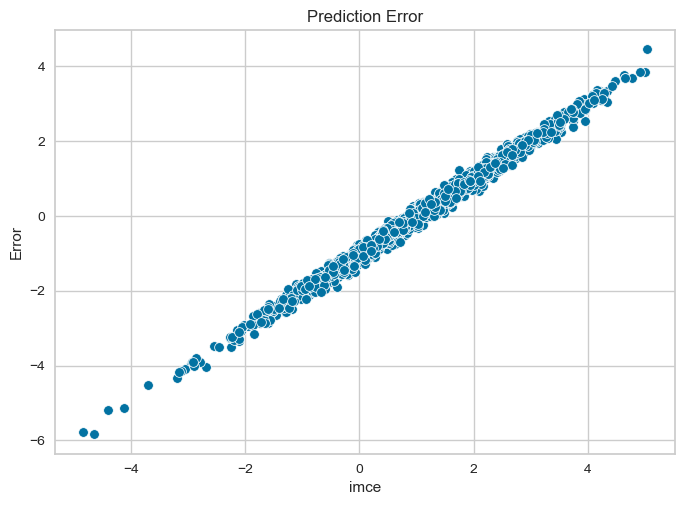

In [26]:
y_pred=pd.DataFrame(y_pred)
y_pred.rename(columns={0 :'Predicted'}, inplace=True )
test = pd.concat([y_test, y_pred], axis=1, join='inner')
test['Error'] = test['imce']-test['Predicted']
sns.scatterplot(data=test, x='imce', y='Error').set_title('Prediction Error')

In [15]:
eli5.show_weights(lasso, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+1.011,<BIAS>
+0.073,sexo
+0.038,sk8
+0.037,sk7
+0.034,madre_work
+0.031,sk5
+0.027,sk12
+0.024,sk10
+0.004,sk13
-0.001,vive_madre


In [16]:
# define model
model = LassoCV(n_alphas=100, cv=cv, n_jobs=-1, max_iter=10000)
# fit model
model.fit(X_train_scaled, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.002316


2. Utilizando el set de datos *charls2.csv* realice una clasificacion de la variable *retired* usando Random Forest sobre las demas variables del dataset con cross-validation. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

**R:** El mejor modelo produce una precision de .90, con el siguiente set de hiperparametros: max_depth = 8, max_features = 8, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 300. Los principales predictores son las horas trabajadas (hrsusu) y la edad al momento de la encuesta.

In [29]:
df=pd.read_csv('../data/charls2.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
target = df.retired
features = df.drop(['retired','retage','retin'], axis=1)
features.describe()

,age,cesd,child,female,hrsusu,hsize,intmonth,married,schadj,urban,wealth
count,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000
mean,58.164356,9.112376,2.780074,0.535272,2.566736,3.764233,7.506931,0.879084,4.039851,0.212005,1479.488490
std,9.374956,6.481237,1.397316,0.498785,1.788298,1.823838,1.001893,0.326050,3.545666,0.408754,43479.865654
min,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1000000.000000
25%,51.000000,4.000000,2.000000,0.000000,0.000000,2.000000,7.000000,1.000000,0.000000,0.000000,0.000000
50%,57.000000,8.000000,3.000000,1.000000,3.496508,4.000000,7.000000,1.000000,4.000000,0.000000,400.000000
75%,64.000000,13.000000,4.000000,1.000000,4.025352,5.000000,8.000000,1.000000,8.000000,0.000000,2200.000000
max,95.000000,30.000000,10.000000,1.000000,5.123964,16.000000,12.000000,1.000000,16.000000,1.000000,900100.000000


In [35]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(max_depth = 8, max_features = 8, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 300, random_state=42)

# Training the classifier
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)

# Evaluating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

confusion_matrix(y_test, y_pred)

Accuracy: 0.9034653465346535


array([[1208,  105],
       [  51,  252]], dtype=int64)

<BarContainer object of 12 artists>

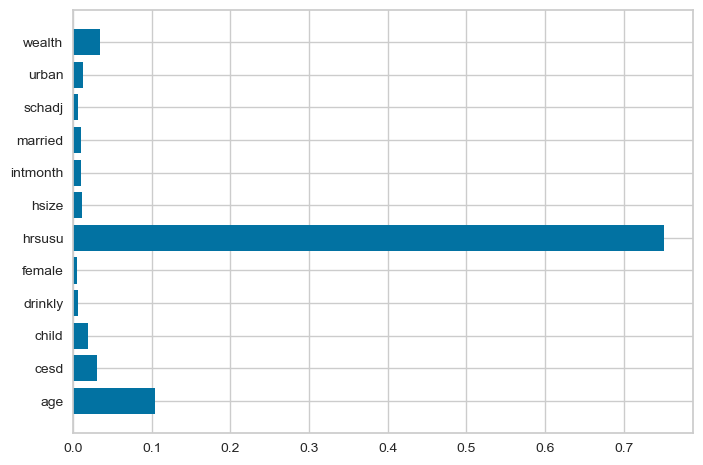

In [36]:
plt.barh(features.columns, rf.feature_importances_)

In [33]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 8, 16],
    'max_features': [6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 8, 16],
                         'max_features': [6, 8], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [34]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
True_8_8_4_10_300,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",1,0.900524,0.012516
True_8_6_5_12_200,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",2,0.900524,0.011082
True_8_6_4_12_100,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",3,0.900369,0.011574
True_16_8_3_12_300,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",4,0.900369,0.012681
True_8_6_5_12_300,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",5,0.900215,0.012155
...,...,...,...,...
True_4_8_3_12_200,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",158,0.895573,0.010144
True_4_8_4_12_300,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",159,0.895573,0.009643
True_16_6_4_8_200,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",160,0.895418,0.012398


3. Repita el analisis de la Pregunta 2 usando Stacking, con tres modelos (Random Forest, Gradient Boosting y SVM). Muestre que sus resultados son robustos a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

**R:** El modelo via Stacking produce una precision menor al modelo RF con los hiperparametros optimos, pero la diferencia es marginal. En base a los resultados se sugiere usar RF para acelerar el proceso. 

In [38]:
from sklearn import svm

estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=8, max_features=8, min_samples_split=10, random_state=42)),
    ('boost', GradientBoostingClassifier(n_estimators=300, learning_rate=0.04, max_depth=8, random_state=42)),
    ('svc', svm.SVC(C=1, gamma=0.0001))]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stack.fit(X_train, y_train).score(X_test, y_test)

0.8985148514851485

In [39]:
cv = cross_val_score(stack, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print('Accuracy: %.6f' % round(np.mean(cv),6))

Accuracy: 0.899286


4. Utilizando la base de datos *enia.csv* realice un analisis de cluster usando k-means incluyendo todas las variables excepto *tamano* y *ID*. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

**R:** Al explorar sobre el espacio de features estandarizados, se observa que K-means identifica un numero alto de clusters sin perdida de informacion, aunque ello conlleva a generar clusters con observaciones, potencialmente identificando outliers de la data. El numero optimo de clusters ignorando aquellos que son observaciones unicas es siete.

In [3]:
df=pd.read_csv('../data/enia.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.export = df.export.astype(int)
df['utilidades']=np.log(df['utilidades']-df['utilidades'].min()+0.1)
features = df.drop(['tamano','ID','year'], axis=1)
features.describe()

,sales,age,foreign,export,workers,fomento,iyd,impuestos,utilidades
count,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000
mean,3.574172,15.305084,0.081859,0.111191,1.757726,0.076105,0.224887,0.203856,5.500845
std,1.692742,12.488330,0.274153,0.314372,1.186507,0.265169,0.417514,15.869466,0.060706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-180.992528,-2.302585
25%,2.337643,7.000000,0.000000,0.000000,0.778151,0.000000,0.000000,0.000000,5.499092
50%,3.553321,14.000000,0.000000,0.000000,1.785330,0.000000,0.000000,0.000007,5.499092
75%,4.539098,20.000000,0.000000,0.000000,2.661813,0.000000,0.000000,0.000167,5.499097
max,10.309005,190.000000,1.000000,1.000000,5.845915,1.000000,1.000000,2981.494528,10.729529


In [4]:
# Split the dataset into training and testing sets
X_train, X_test = train_test_split(features, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\juanc\anaconda3\lib\site-packages\sklearn\clust

0    8263
4    7940
7    4432
6    3937
2    2379
1    2257
5    2073
3       1
8       1
dtype: int64

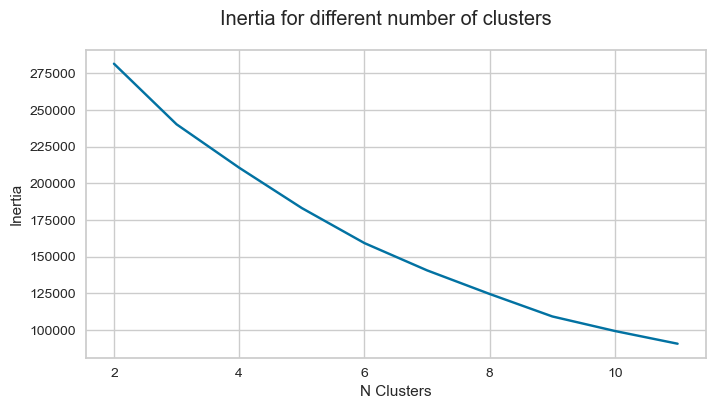

In [5]:
total_clusters = 10
param_search = pd.DataFrame({
    "N Clusters": np.arange(2,total_clusters+2,dtype=int), 
    "Inertia": [0]*total_clusters
})
for n_clusters in range(total_clusters):
    param_search.loc[n_clusters, "Inertia"] = KMeans(n_clusters=n_clusters+1, random_state=1).fit(X_train_scaled).inertia_

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.lineplot(data=param_search, x="N Clusters", y="Inertia", ax=ax)
fig.suptitle("Inertia for different number of clusters")
fig.show()

n_clusters = 9
cluster_labels = pd.Series(KMeans(n_clusters=n_clusters, random_state=1).fit(X_train_scaled).labels_)
cluster_labels.value_counts()


c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\juanc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(35.23204204917169, 0.5, 'sales')

<Figure size 1500x800 with 0 Axes>

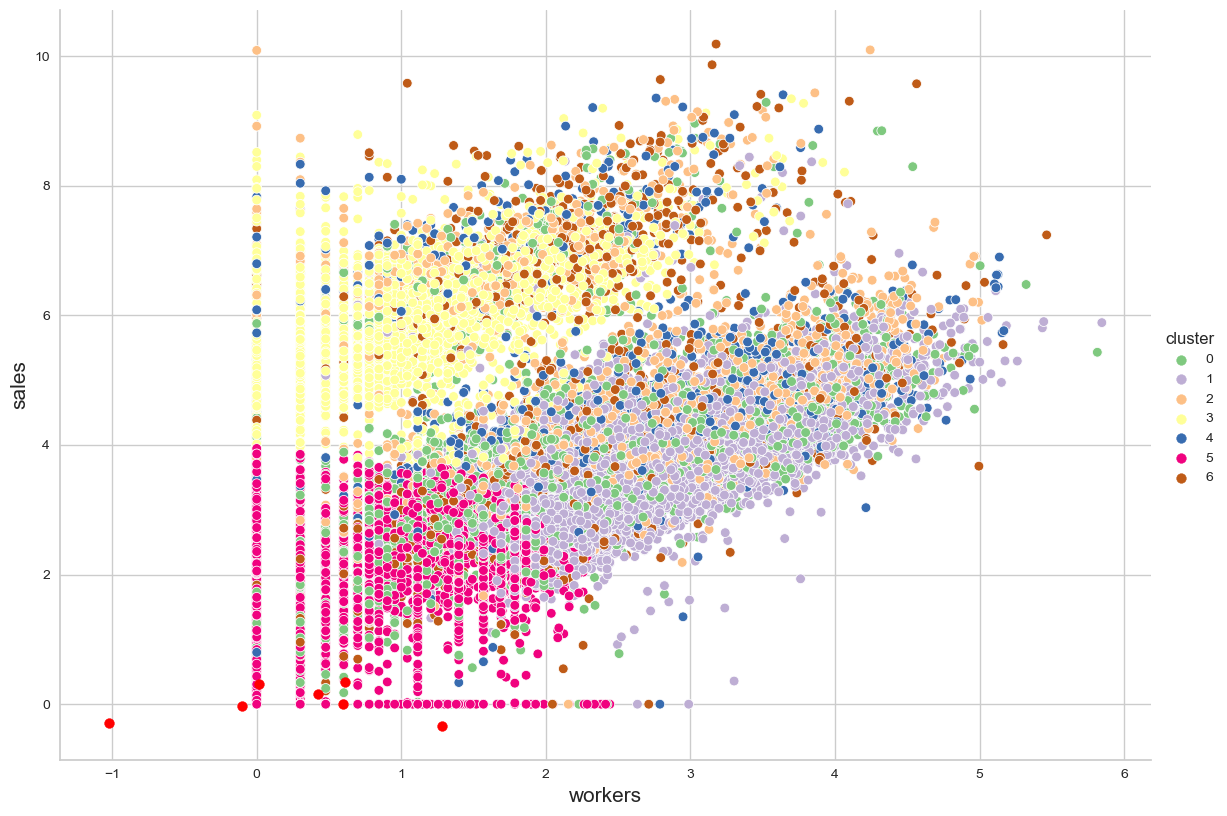

In [8]:
kmeans = KMeans(n_clusters=7,init= "random", random_state = 1).fit(X_train_scaled)
y_kmeans = kmeans.fit_predict(X_train_scaled)
centroids = kmeans.cluster_centers_
plt.figure(figsize=(15,8))
Data_kmean = X_train.copy()
Data_kmean['cluster'] = kmeans.labels_
sns.relplot(data = Data_kmean ,x='workers' , y  ='sales', hue='cluster', palette='Accent' ,kind='scatter', height=8.27, aspect = 11.7/8.27)
plt.scatter(centroids[:, 0], centroids[:,1], c='red', s=50)
plt.xlabel("workers",fontsize=15)
plt.ylabel("sales",fontsize=15)

In [9]:
Data_kmean['cluster'].value_counts()

5    8244
1    7970
0    4430
3    3937
2    3040
6    2114
4    1548
Name: cluster, dtype: int64

5. Repita el analisis de la Pregunta 4 usando DBSCAN. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

**R:** Al repetir el mismo analisis anterior con DBSCAN, encontramos tres clusters en vez de siete (parametros optimizados en funcion de la distancia de los vecinos mas proximos).

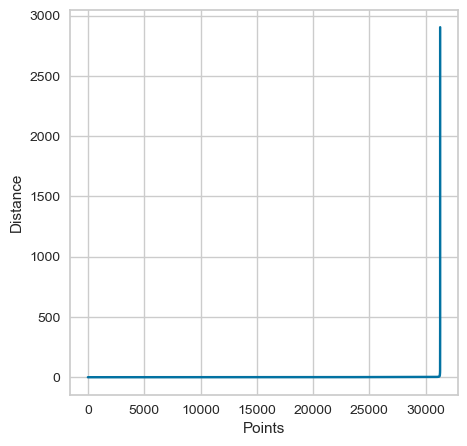

In [23]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_train)
distances, indices = neighbors.kneighbors(X_train)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

Number of clusters: 3


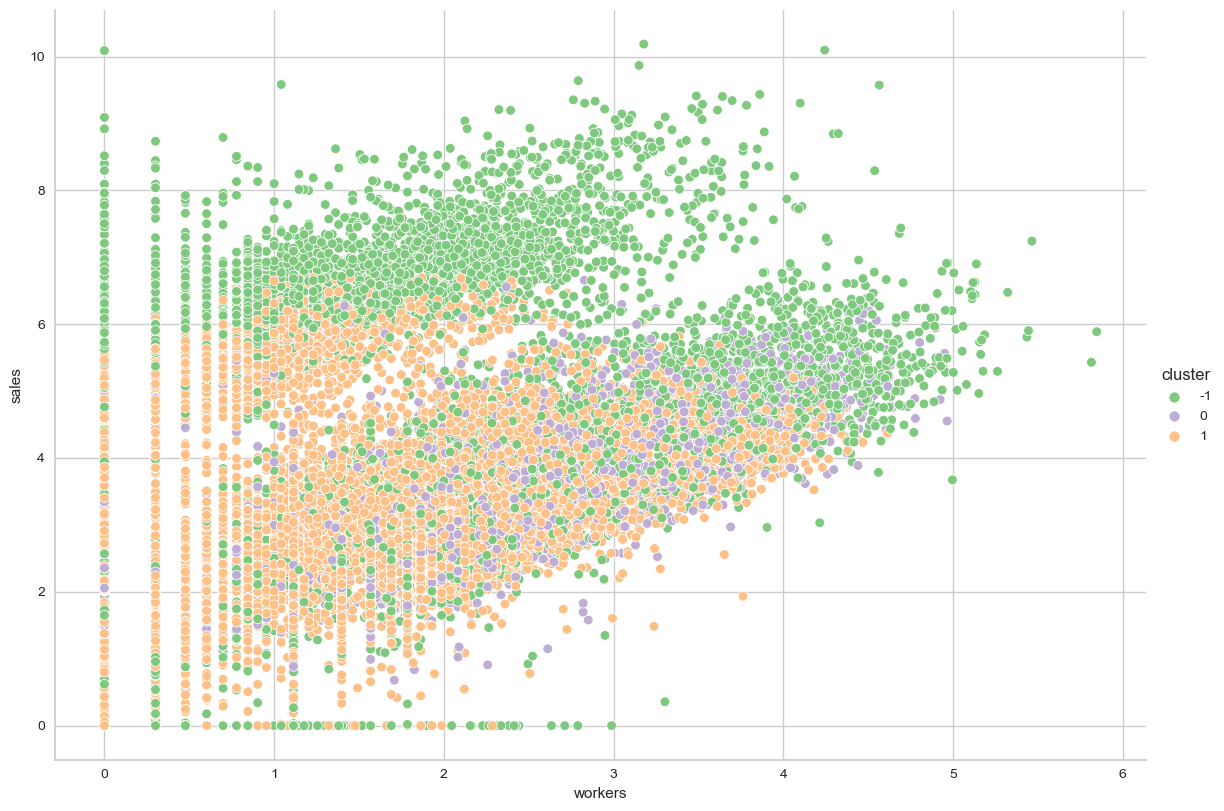

In [26]:
dbscan = DBSCAN(eps=2, min_samples=1500)
# Fit the DBSCAN model to the data
dbscan.fit(X_train)
# Extract the cluster labels
labels = dbscan.labels_
# Print the number of clusters
n_clusters = len(np.unique(labels))
print(f"Number of clusters: {n_clusters}")

data_dbscan = X_train.copy()
data_dbscan['cluster'] = dbscan.labels_
sns.relplot(data = data_dbscan ,x='workers' , y  ='sales', hue='cluster', palette='Accent' ,kind='scatter', height=8.27, aspect = 11.7/8.27)

In [27]:
data_dbscan['cluster'].value_counts()

 1    17777
-1     9276
 0     4230
Name: cluster, dtype: int64